# Double DQN

## Relembrando alguns conceitos

**Algoritmo de Q-Learning:** 

$$
Q(s,a) \leftarrow Q(s,a) + \alpha [R_{t+1} + \gamma \cdot  \max_{a'} Q'(s', a') - Q(s,a)]
$$

Esse algoritmo, como sabemos, tem como objetivo atualizar as estimativas dos Q valores para os pares estado-ação do ambiente. O valor de Q é atualizado por meio de uma "parcela de correção de erro" (parcela de atualização), com uma taxa de aprendizado α.

A atualização é composta pela recompensa imediata pela última ação tomada $R_{t+1}$, o fator de desconto $γ$ multiplicando o maior valor possível esperado de retorno naquele novo estado (após a última ação) menos o valor atual de $Q$.

**DQN:**

Para problemas em que o método tabular não dá conta, como visto no [notebook de DQN](../Deep%20Q-Network), utilizamos uma rede neural para estimar os valores Q. Porém, ao utilizar somente uma rede neural, os valores de Q tendem a ser superestimados, gerando treinamento menos eficiente e podendo levar a políticas sub-ótimas. Para tentar estabilizar o treinamento, utilizaremos então uma segunda rede neural, chegando no algoritmo DDQN.

## Teoria
Talvez você tenha notado que no algoritmo de Q-learning nós utilizamos uma estimativa do q-valor para fazer uma estimativa do nosso q-valor, as DDQN's surgiram com o objetivo de lidar com este problema.

Nossa equação para o bootstrap é a seguinte:

$$
Q_{bootstrap}(s,a) = R_{t+1} + \gamma \cdot \max_{a}Q(s',a)
$$

O Q target vira a soma da recompensa ao tomar a ação $a$ no estado $s$, mais o valor máximo de **Q** dentre todas as possíveis ações. Repare que, basicamente o que estamos fazendo é criar uma estimativa nova que depende dela mesma; que depende de uma estimativa anterior que está constantemente mudando:

A função de custo (J) que usaremos para os pesos da rede é dado pela fórmula:

$$
J(w) = \mathbf{E} [(q(s,a) - Q_w(s,a))^2]
$$

Em que **q(s,a)** é a função valor-ação real do nosso problema, e **Qw(s,a)** é o valor estimado a partir dos pesos da rede neural.

Mas o problema enfrentado é que não temos o **q(s,a)**.

O que fazemos então é aproximar nosso **q(s,a)**, obtendo também um **J(w)** aproximado:

$$
J(w)_{bootstrap} = \mathbf{E} [(Q_{bootstrap}(s,a) - Q_w(s,a))^2]
$$

Mas o que pode acontecer a partir disso é que estaremos escolhendo ações que possuem o maior q-valor sem ter tanta certeza de que isso não é um falso positivo, de que não estamos obtendo um q-valor maior para ações não ótimas do que para ações ótimas.

### Solução:

Quando calcularemos o $Q_{bootstrap}$ nós usaremos duas redes idênticas para separar a escolha de melhor ação do cálculo do q-valor. 

  - Usamos uma rede DQN $Q_{local}$ para selecionar qual é a melhor ação a ser tomada no próximo estado. (Ação com maior q-valor).

  -  Usamos uma rede DQN $Q_{target}$ para calcular o q-valor de tomar essa ação no próximo estado.

Ou seja:

  - Rede DQN para escolher melhor ação para o próximo estado:
    $\arg\max_a(Q_{local}(s',a))$

  - Rede $Q_{fixo}$ calculando $Q$ valor da escolha acima:
    $Q_{target}(s', \arg\max_a Q_{local}(s',a))$

E seguimos com nossa expressão do TD Target:
$Q_{local}(s,a) = R_{t+1} + \gamma \cdot Q_{target}(s', \arg\max_a Q_{local}(s',a))$

  Dessa maneira, com um $Q_{target}$ nós conseguimos "fixar" um valor para ser aproximado pelo $Q_{local}$, simplificando como a rede pode maximizar o q-valor com um viés menor e de maneira mais estável. 

Importante notar que faremos apenas o proceso de *backpropagation* na rede local. Para a rede alvejada nós copiaremos os parâmetros de uma para a outra, com um parâmetro $\tau$ definindo quanto uma influênciará a outra.

## Importações

In [1]:
import sys
import gym
import math
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Utilizaremos o mesmo Experience Replay que utilizamos na DQN comum.

In [3]:
sys.path.insert(1, '../Experience Replay')
from ReplayBuffer import ReplayBuffer

## Rede Neural

Como você pode ver a Rede Neural é a mesma da DQN comum, a diferença é que iremos utilizá-la duas vezes. Aqui utilizaremos apenas a rede linear, se você se interessar, pode ser um exercício interessante adaptar esse código à rede convolucional.

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Network(nn.Module):
    """
    Cria uma rede neural para DQN
    """
    def __init__(self, in_dim, out_dim):
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 64), 
            nn.ReLU(),
            nn.Linear(64, 64), 
            nn.ReLU(), 
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        return self.layers(x)

## Agente

Muitos dos parâmetros utilizados pelo Agente Double-DQN são análogos ao Agente DQN:
- ```lr```: a taxa de aprendizado, ou seja, o quanto que levaremos em conta um novo cálculo na atualização do nosso Q-valor
- ```gamma```: o fator de desconto, que diz o quanto consideramos recompensas futuras em relação a recompensas instantâneas
- ```max_memory```: o número de tuplas que iremos armazenar no nosso replay buffer 
- ```epsilon_init```: o valor inicial do nosso $\epsilon$, que diz o quanto nosso agente explora ou explota
- ```epsilon_decay```: o quanto que iremos diminuir o $\epsilon$
- ```min_epsilon```: o menor valor de $\epsilon$
- ```network```: o tipo de rede que usaremos no nosso problema, ou seja, linear ou convolucional

O parâmetro introduzido na DDQN é:
- ```tau```: parâmetro mediador entre as duas redes neurais; o quanto a rede local irá influenciar a rede alvejada.

Os métodos implementados para nosso agente são:
- ```act```: usado para escolher uma ação com base na política atual, em relação ao estado presente
- ```remember```: salva no Replay Buffer uma tupla de experiência
- ```train```: treina o agente


In [5]:
class DDQNAgent:
    """
    Uma classe que cria um agente com Double-DQN, com um experience replay padrão.
    """
    def __init__(self,
                obs_space,
                action_space,
                lr=3e-4,
                gamma=0.99,
                tau=0.001,
                max_memory=100000,
                batch_size=32,
                eps_init=0.9,
                eps_decay=0.9995,
                eps_min=0.01):

        """
        Inicializa o agente com os parâmetros dados
        
        Parâmetros
        ----------
        
        observation_space: gym.spaces
        O espaço de observação do gym
         
        action_space: gym.spaces
        O espaço de ações do agente modelado no gym
        
        lr: floar, default=3e-4
        A taxa de aprendizado do agente
        
        gamma: float, default=0.99
        O fator de desconto. Se perto de 1. as recompensas futuras terão grande importância,
        se perto de 0. as recompensas mais instantâneas terão maior importância
        
        tau: float, default=0.001
        O quanto a rede local irá influenciar a rede alvejada.

        max_memory: int, default=100000
        O número máximo de transições armazenadas no buffer de memória
        
        epsilon_init: float, default=0.5
        O epsilon inicial do agente. Se próximo de 1. o agente tomará muitas ações
        aleatórias, se proóximo de 0. o agente escolherá as ações com maior
        Q-valor
        
        epsilon_decay: float, default=0.9995
        A taxa de decaimento do epsilon do agente. A cada treinamento o agente tende
        a escolher meno ações aleatórias se epsilon_decay<1
        
        min_epsilon: float, default=0.01
        O menor epsilon possível
        
        
        network: str, default='linear'
        O tipo de rede a ser utilizada para o agente DQN. Por padrão é usada uma rede linear, mas
        pode ser usada uma rede convolucional se o parâmetro for 'conv'
        
        Retorna
        -------
        None
        """

        self.device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

        self.memory = ReplayBuffer(max_memory, obs_space.shape[0])

        self.batch_size = batch_size

        self.action_space = action_space

        self.lr = lr
        self.gamma = gamma
        self.tau = tau

        self.eps = eps_init
        self.eps_decay = eps_decay
        self.eps_min = eps_min

        self.dqn = Network(obs_space.shape[0], action_space.n).to(self.device)
        self.target_dqn = Network(obs_space.shape[0], action_space.n).to(self.device)
        self.target_dqn.eval()

        # Copia os parâmetros do modelo aos parâmetros do modelo alvo
        for target_param, param in zip(self.dqn.parameters(),self.target_dqn.parameters()):
            target_param.data.copy_(param)

        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)

    def act(self, state):
        self.eps *= self.eps_decay
        self.eps = max(self.eps, self.eps_min)

        if np.random.random() < self.eps:
            action = self.action_space.sample()
            return action
        
        with torch.no_grad():
            state = torch.FloatTensor(state).to(self.device)
            action = self.dqn.forward(state).argmax(dim=-1)
            action = action.cpu().numpy()
        
        return action

    def remember(self, state, action, reward, next_state, done):
        self.memory.update(state, action, reward, next_state, done)
    
    def train(self):

        # Se temos menos experiências que o batch size
        # não começamos o treinamento
        if self.batch_size * 10 > self.memory.size:
            return

        # Pegamos uma amostra das nossas experiências para treinamento
        (states, actions, rewards, next_states, dones) = self.memory.sample(self.batch_size)

        # Transformar nossas experiências em tensores
        states = torch.as_tensor(states).to(self.device)
        actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
        rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
        next_states = torch.as_tensor(next_states).to(self.device)
        dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)

        curr_q = self.dqn.forward(states).gather(-1, actions.long())

        with torch.no_grad():
            next_q = self.target_dqn.forward(next_states).max(dim=-1,keepdim=True)[0]

            target = (rewards + (1 - dones) * self.gamma * next_q).to(self.device)

        loss = F.mse_loss(curr_q, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Atualizar a rede alvejada
        for target_param, param in zip(self.target_dqn.parameters(), self.dqn.parameters()):
            target_param.data.copy_(self.tau * param + (1 - self.tau) * target_param)

### Definação de parâmetros

In [6]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

In [7]:
BATCH_SIZE = 32
GAMMA = 0.99
TAU = 0.01
EPS_INIT = 0.7
EPS_END = 0.05
EPS_DECAY = 0.9995
MAX_MEMORY = 100000
OBS_SPACE = env.observation_space
ACT_SPACE = env.action_space

In [8]:
agent = DDQNAgent(obs_space = OBS_SPACE,
                    action_space = ACT_SPACE,
                    lr=3e-4,
                    gamma=GAMMA,
                    tau=TAU,
                    max_memory=MAX_MEMORY,
                    batch_size=BATCH_SIZE,
                    eps_init=EPS_INIT,
                    eps_decay=EPS_DECAY,
                    eps_min=EPS_END)

## Treinando e Loop

In [9]:
def train(agent, env, timesteps, render=False):
    
    total_reward = 0
    episode_returns = deque(maxlen=20)
    avg_returns = []
    episode = 0

    state = env.reset()
    done = False 
    
    for timestep in range(1, timesteps+1):       
        
        action = agent.act(state)

        next_state, reward, done, info = env.step(action)

        agent.remember(state, action, reward, next_state, done)

        agent.train()  
        
        total_reward += reward
        
        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state = env.reset()
        
        if episode_returns:
            avg_returns.append(np.mean(episode_returns))
            
        total_reward *= 1 - done
        ratio = math.ceil(100 * timestep / timesteps)
        avg_return = avg_returns[-1] if avg_returns else np.nan
        
        state = next_state

        if render:
            env.render()

        print(f"\r[{ratio:3d}%] timestep = {timestep}/{timesteps}, episode = {episode:3d}, avg_return = {avg_return:10.4f}", end="")   
            
    return avg_returns

In [10]:
timesteps = 40000
train_returns = train(agent, env, timesteps, render=False)

[100%] timestep = 40000/40000, episode = 278, avg_return =   210.3500

### Curva de aprendizado

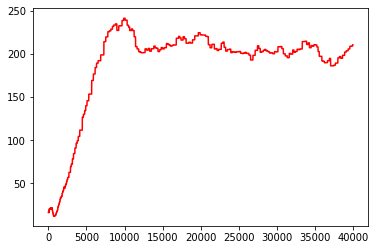

In [11]:
plt.plot(train_returns, 'r')
plt.show()